# Battery Heater Thresholds

In [1]:
from glob import glob
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import parse

## File Input

Read all datasets found in the `SatelliteData` directory via Pandas. `Parse.readFile()` performs filtering and conversion as well: it changes the timestamps from milliseconds since epoch to Datetime objects, and rejects temperatures outside of $-50^\circ \text{C} < T < 50^\circ \text{C}$.

In [2]:
filepaths = glob('./SatelliteData/satellite*.csv')
dfs  = {} # Dictionary to hold dataframes
for path in filepaths:
    sat = path[25:-4] # pull out the HWID
    dfs[sat] = parse.readFile(path)

## Time Series View

Since we want the temperatures to stay above $0^\circ \text{C}$, we can check how effective our control schemes are by viewing the time series of each satellite's battery pack temperatures. #TODO: make note

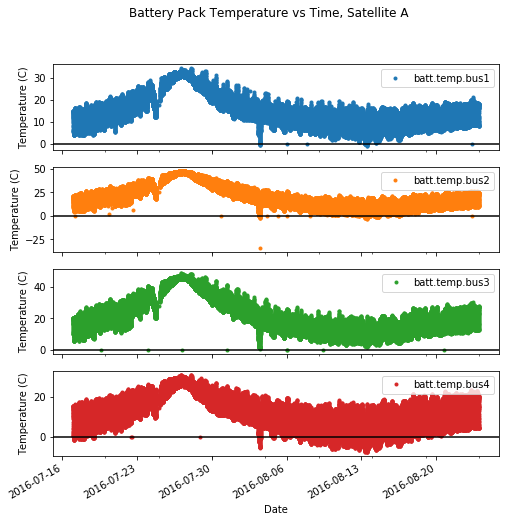

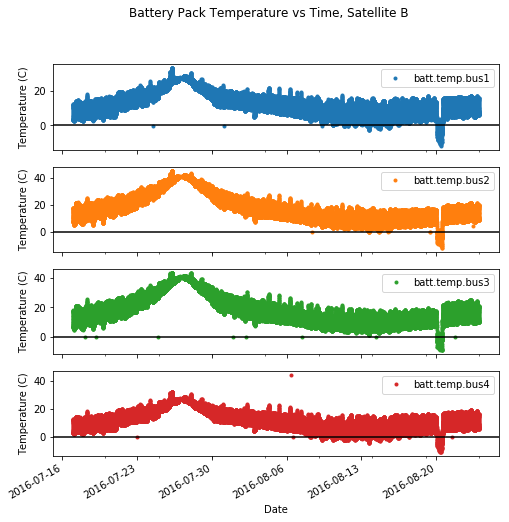

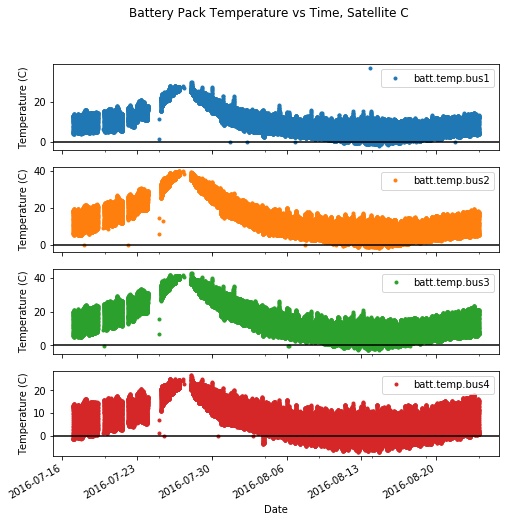

In [3]:
for sat in sorted(dfs.keys()):
    parse.plotTime(dfs[sat], sat)
plt.show()

## Temperature Distribution

A better way to quantitatively analyze how well the temperature stays in our bounds is by looking at the temperature distribution. #TODO: note results 

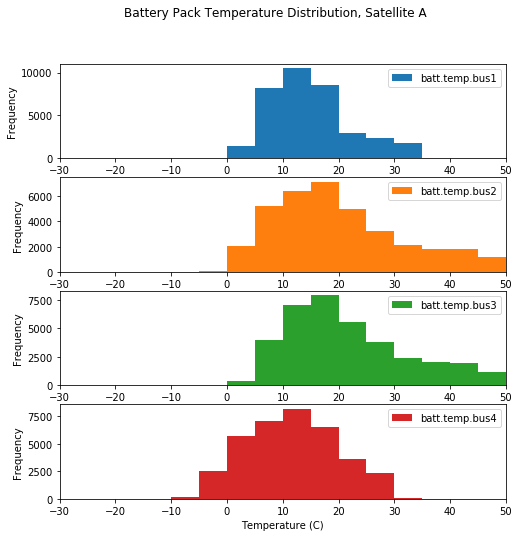

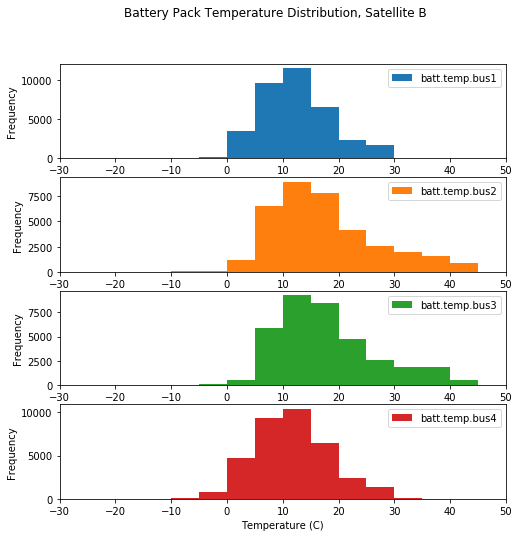

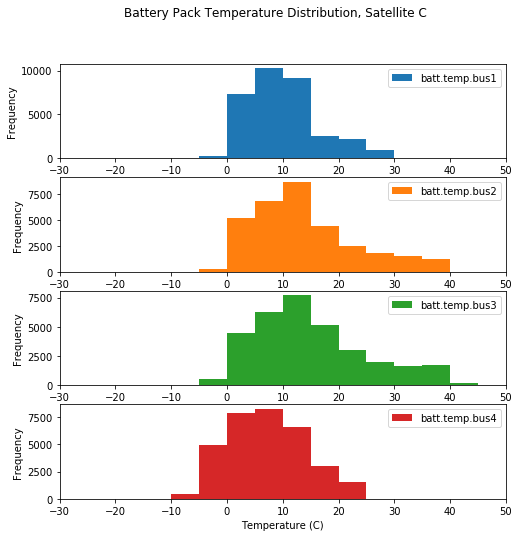

In [4]:
for sat in sorted(dfs.keys()):
    parse.plotDist(dfs[sat], sat)
plt.show()

## Filtering by Threshold

In order to examine how effective the new heating thresholds are, we can partition the data into an active experiment set (with $T_{\text{on}}/T_{\text{off}} = 11/16^\circ \text{C}$) and a set where the experiment is inactive ($T_{\text{on}}/T_{\text{off}} = 5/10^\circ \text{C}$).

In [5]:
activeA = dfs['A'][dfs['A']['timestamp'] >= datetime.fromisoformat('2016-07-20T23:09:46')]
inactiveA = dfs['A'][dfs['A']['timestamp'] < datetime.fromisoformat('2016-07-20T23:09:46')]

activeB = dfs['B'][dfs['B']['timestamp'] >= datetime.fromisoformat('2016-07-21T02:34:52')]
inactiveB = dfs['B'][dfs['B']['timestamp'] < datetime.fromisoformat('2016-07-21T02:34:52')]

One interesting thing to note is that both satellites reboot shortly after the new thresholds become active. Presumably, this is happening during a pass with a ground station, so the thresholds become active within minutes.

In [6]:
activeA.head()

,timestamp,batt.temp.bus1,batt.temp.bus2,batt.temp.bus3,batt.temp.bus4,sc.bootcount
3877,2016-07-20 23:10:38.054,10.4375,13.50,15.4375,5.375,NaN
3878,2016-07-20 23:10:42.540,NaN,NaN,NaN,NaN,228.0
3879,2016-07-20 23:11:23.967,NaN,NaN,NaN,NaN,228.0
3880,2016-07-20 23:12:07.113,10.1875,12.75,14.7500,4.875,NaN
3881,2016-07-20 23:12:07.297,10.1875,12.75,14.7500,4.875,NaN


In [7]:
activeB.head(8)

,timestamp,batt.temp.bus1,batt.temp.bus2,batt.temp.bus3,batt.temp.bus4,sc.bootcount
4099,2016-07-21 02:36:00.926,NaN,NaN,NaN,NaN,16.0
4100,2016-07-21 02:36:07.097,10.0625,16.2500,15.5625,9.2500,NaN
4101,2016-07-21 02:36:58.184,NaN,NaN,NaN,NaN,16.0
4102,2016-07-21 02:37:15.368,9.9375,16.0000,15.3125,9.1250,NaN
4103,2016-07-21 02:37:37.085,9.8750,15.9375,15.2500,9.0625,NaN
4104,2016-07-21 02:37:49.522,NaN,NaN,NaN,NaN,16.0
4105,2016-07-21 02:39:08.058,9.8125,15.6875,15.0000,9.0000,NaN
4106,2016-07-21 02:40:37.121,9.7500,15.5625,14.8750,8.9375,NaN


The datasets are combined together, then we can again look at the time series and distribution of the temperatures.

In [8]:
active = pd.concat([activeA, activeB], keys=['A', 'B'])
inactive = pd.concat([dfs['C'], inactiveA, inactiveB], keys=['C', 'A', 'B'])

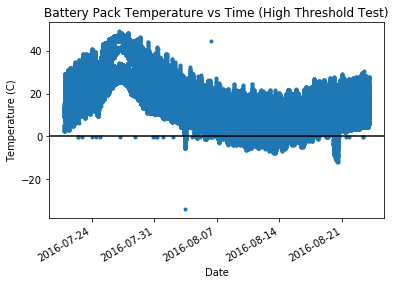

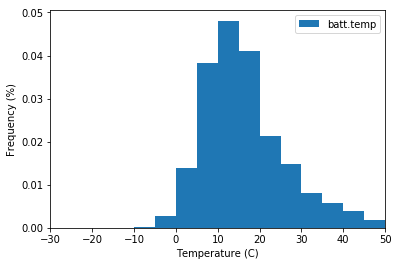

In [9]:
parse.plotReduce(active,'High Threshold Test')
plt.show()

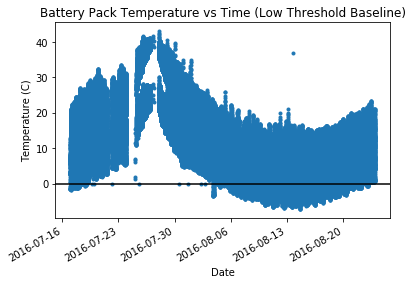

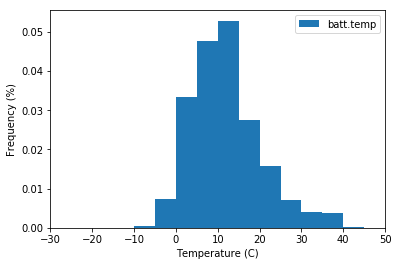

In [10]:
parse.plotReduce(inactive,'Low Threshold Baseline')
plt.show()

## Effects of Beta Angle

## Other Considerations
Though the higher thresholds were more effective in maintaining the battery temperature ($T>0^\circ\text{C}$), there are several possible drawbacks to this approach.

 Temperature of other components (scope&lens in particular, computer, radio, etc.)
 
 Wear and tear on patch heaters
 
 Individual differences between satellites (even between different heaters)
 
 different orbits with different sunlight fractions
 
 Has a heater ever been stuck on? effects

## Scratch Work

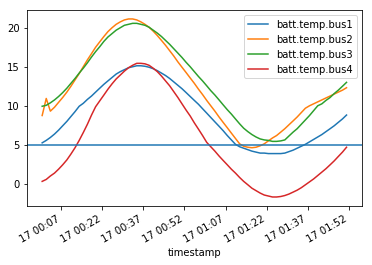

In [11]:
ax = dfs['A'].head(75).plot(x='timestamp', y=['batt.temp.bus1','batt.temp.bus2','batt.temp.bus3','batt.temp.bus4'])
ax.axhline(y=5)